In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tifffile import imsave, imread
import os

os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP')
from gap.BinomDatasetv3 import BinomDataset 
from gap.GAP_UNET_ResBlockv2 import UN
from gap.tasks import inpainting

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.utils.data as dt

if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

print(f'Device in use: {device}')

Device in use: cuda:0


(2048, 512, 512)


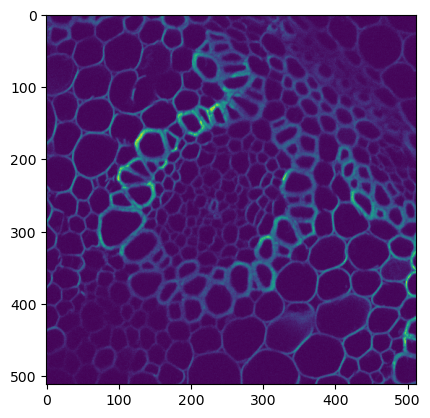

In [2]:
data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingDataGT.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')))
plt.imshow(data[0])
print(data.shape)

In [3]:
name = 'm40tom5-256x256-inpainting-trial'
minpsnr = -40
maxpsnr = -5
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'

In [4]:
maxepochs = 2

masks = inpainting()
mask = torch.from_numpy(masks.generate_mask())

dataset = BinomDataset(data = data[:round(data.shape[0]*0.9)], windowSize= 256, minPSNR=minpsnr, maxPSNR=maxpsnr, mask = mask)
val_dataset = BinomDataset(data = data[round(data.shape[0]*0.9):], windowSize=256, minPSNR=minpsnr, maxPSNR=maxpsnr, mask = mask)

train_loader = dt.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True, pin_memory=False, num_workers=1) ## Changing the batch size from 32 to 16 to fit inside the gpu
val_loader = dt.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False,  pin_memory=False, num_workers=1)

trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     accelerator= 'gpu',
                     max_epochs=maxepochs, 
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss", every_n_epochs = 5, filename= name, dirpath= CHECKPOINT_PATH),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=2000)])

model = UN(channels = 1, levels=1, depth=3, mask = mask.to(device),
           start_filts=28, up_mode = 'transpose').to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/GAP_UNET_ResBlockv2.py:257: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/GAP_UNET_ResBlockv2.py:258: UserWarning: nn.init.constant is now deprecated i

In [5]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_final | Conv2d     | 29     | train
1 | down_convs | ModuleList | 368 K  | train
2 | up_convs   | ModuleList | 137 K  | train
--------------------------------------------------
505 K     Trainable params
0         Non-trainable params
505 K     Total params
2.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [6]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')